In [1]:
import chart_studio.plotly as py
import pandas as pd
import numpy as np
from  plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Data cleaning for Sankey

Graph 1: A particular quantile and a particular lead time
- Step 1: get the target column from classifer.csv
- Step 2: classify columns into TP, TN, FP, FN
- Step 3: get true label column
- Step 4: create two df in the following format

Node_df

|    ID      |label                   |Color|
| --- | --- | --- |
|    0       |Pred Extreme            |Red|
|    1       |Pred No Extreme         |Green|
|    2       |Extreme Weather         |Blue|
|    3       |No Extreme Weater       |Gray|
4
5

Link_df

|Source(pred) |Target(label) |Value    |Color     | 
| --- | --- | --- | --- |
|0            |2             |TP       |Light Red | 
|0            |3             |FP       |Bright Red    |
|1            |2             |FN       |Light green   |
|1            |3             |TN       |Bright green  |


Link_df

|Source(pred) |Target(label) |Value    |Color     | 
| --- | --- | --- | --- |
|0            |2             |TP       |Light Red | 
|0            |3             |FP       |Bright Red    |
|1            |2             |FN       |Light green   |
|1            |3             |TN       |Bright green  |
|2            |4             |TP       |Light Red | 
|2            |5             |FP       |Bright Red    |
|3            |4             |FN       |Light green   |
|3            |5             |TN       |Bright green  |


In [2]:
# read classifier result
key = '1d_precip_location_final1' # not v9 but retrained tuned models 
rname = 'results/classifier_outcomes_%s.csv' % key
outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)
outcomes = outcomes[3932:]
CNN9_0 = (outcomes['CNN_0_0.90']> 0.5)

# read benchmark
bm_matrix = pd.read_csv('results/benchmark_matrix_precip_apples.csv', index_col=0, parse_dates=True)
GEFS9_0 = bm_matrix['GEFS_0_0.90']

In [3]:
# read classifier result
key = '1d_precip_location_final1' # not v9 but retrained tuned models 
rname = 'results/classifier_outcomes_%s.csv' % key
outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)
outcomes = outcomes[3932:]
CNN9_0 = (outcomes['CNN_4_0.90']> 0.5)

# read benchmark
bm_matrix = pd.read_csv('results/benchmark_matrix_precip_apples.csv', index_col=0, parse_dates=True)
GEFS9_0 = bm_matrix['GEFS_4_0.90']

In [4]:
leads = [d for d in range(14)]
quantiles = [0.50, 0.75, 0.9, 0.95]

def create_con_matrix_vs_benchmark(key):
    rname = 'results/classifier_outcomes_%s.csv' % key
    outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)
    binary_outcomes = outcomes.copy()
    for col in outcomes.columns[1:]:
        if outcomes[col].dtypes == 'float64':
            binary_outcomes[col] = (outcomes[col]> 0.5)


    con_precip_vs = pd.DataFrame(bm_matrix['ERA5']) #'ERA5'

    for q in quantiles:
        con_precip_vs['ERA_%0.2f_ERA' %q] = outcomes['ERA5_%0.2f' %q]
        for l in leads:
            label = bm_matrix['ERA5_%0.2f' % q] #'ERA5'
            bm_pred =  bm_matrix['GEFS_%d_%0.2f' % (l, q)]
            m_pred = pred =  binary_outcomes['CNN_%d_%0.2f' % (l, q)] # this draws from stored variable - binary_outcomes 
            
            con_precip_vs['VS_%d_%0.2f_PPN' % (l, q)] = (label&m_pred&~bm_pred) # corrected wrong bm_pred
            con_precip_vs['VS_%d_%0.2f_NNP' % (l, q)] = (~label&~m_pred&bm_pred) # corrected wrong bm_pred
            con_precip_vs['VS_%d_%0.2f_PNP' % (l, q)] = (label&~m_pred&bm_pred ) # changed good bm_pred to incorrect because of FN
            con_precip_vs['VS_%d_%0.2f_NPN' % (l, q)] = (~label&m_pred&~bm_pred) # change good bm_pred to incorrect because of FP
            con_precip_vs['VS_%d_%0.2f_PNN' % (l, q)] = (label&~m_pred&~bm_pred) # unchanged bad pred
            con_precip_vs['VS_%d_%0.2f_NPP' % (l, q)] = (~label&m_pred&bm_pred) # unchanged bad pred
            con_precip_vs['VS_%d_%0.2f_NNN' % (l, q)] = (~label&~m_pred&~bm_pred) # good as always
            con_precip_vs['VS_%d_%0.2f_PPP' % (l, q)] = (label&m_pred&bm_pred) # good as always

            'PPP', 'PPN', 'PNP','PNN','NPP','NPN','NNP','NNN'
            
    return con_precip_vs

In [5]:
con_cube = create_con_matrix_vs_benchmark('1d_precip_location_final1')

In [6]:
# df = con_cube['2011-01-01':'2019-12-31'].filter(regex="ERA_0.90|VS_0_0.90")
df = con_cube['2011-01-01':'2019-12-31'].filter(regex="ERA_0.90|VS_9_0.90")

In [7]:
d = dict(zip(df.columns, [col[-3:] for col in df.columns]))
df = df.rename(columns=d)

In [8]:
df.sum(axis=0)

ERA     143
PPN      28
NNP       9
PNP       5
NPN      93
PNN      70
NPP      52
NNN    1064
PPP      40
dtype: int64

In [9]:
import seaborn as sns
diverging_colors =  sns.diverging_palette(220, 20, n=8)

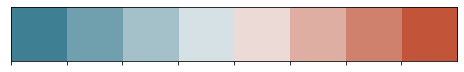

In [10]:
sns.palplot(diverging_colors)

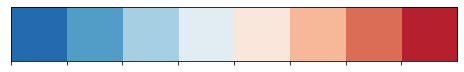

In [11]:
diverging_colors = sns.color_palette("RdBu_r", 8)
sns.palplot(diverging_colors)


In [22]:
diverging_colors[0]

(0.142483660130719, 0.4173010380622838, 0.6833525567089581)

In [12]:
dc1 = 'rgba'+str(diverging_colors[0])
dc2 = 'rgba'+str(diverging_colors[1])
dc3 = 'rgba'+str(diverging_colors[2])
dc4 = 'rgba'+str(diverging_colors[3])
dc5 = 'rgba'+str(diverging_colors[4])
dc6 = 'rgba'+str(diverging_colors[5])
dc7 = 'rgba'+str(diverging_colors[6])
dc8 = 'rgba'+str(diverging_colors[7])

In [13]:
dc1[:-1]+', 0.5)'

'rgba(0.142483660130719, 0.4173010380622838, 0.6833525567089581, 0.5)'

In [14]:
dc1_a = dc1[:-1]+', 0.5)'
dc2_a = dc2[:-1]+', 0.5)'
dc3_a = dc3[:-1]+', 0.5)'
dc4_a = dc4[:-1]+', 0.5)'
dc5_a = dc5[:-1]+', 0.5)'
dc6_a = dc6[:-1]+', 0.5)'
dc7_a = dc7[:-1]+', 0.5)'
dc8_a = dc8[:-1]+', 0.5)'

In [15]:
df_nodes = {'ID': [0,1,2,3,4,5,6,7,8,9,10,11,12,13], 'label': ['Positive', 'Negative', 'TP', 'FN','FP', 'TN', 'PPP', 'PPN', 'PNP','PNN','NPP','NPN','NNP','NNN'],
           'color': ['#D0CECE', '#D0CECE',dc1,dc8,dc7,dc2,dc2,dc1,dc8,dc6,dc5,dc7,dc3,dc4]}
df_nodes = pd.DataFrame(data=df_nodes)
df_links = {'source': [0,0,1,1,2,2,3,3,4,4,5,5], 'target': [2,3,4,5,6,7,8,9,10,11,12,13], 
            'value':[df['PPP'].sum()+df['PPN'].sum(), 
                     df['PNP'].sum()+df['PNN'].sum(), 
                     df['NPP'].sum()+df['NPN'].sum(), 
                     df['NNP'].sum()+df['NNN'].sum(),
                     df['PPP'].sum(),
                     df['PPN'].sum(),
                     df['PNP'].sum(),
                     df['PNN'].sum(),
                     df['NPP'].sum(), 
                     df['NPN'].sum(), 
                     df['NNP'].sum(), 
                     df['NNN'].sum()],
            'color':[dc1_a, dc8_a, dc7_a, dc2_a,
                     dc3_a, dc1_a, dc8_a, dc6_a, dc5_a, dc7_a, dc2_a, dc4_a]}
df_links = pd.DataFrame(data=df_links)

In [23]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]

data_trace = dict(
    type='sankey',
    arrangement='snap',
#     domain = dict(
#       x =  [0,1],
#       y =  [0,1]
#     ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['label'],
      color = df_nodes['color']
    ),
    link = dict(
      source = df_links['source'],
      target = df_links['target'],
      value = df_links['value'],
      color = df_links['color'],
  )
)

layout = dict(
        title = "Confusion Matrix (Quantile = 0.90, Lead time = 10)",
    height = 500,
    width = 500,
    margin=dict(
    l=50,
    r=50,
    b=50,
    t=50,
    pad=4
    ),
    font = dict(
      size = 12),
)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

In [36]:
df_nodes = {'ID': [0, 1, 2, 3, 4, 5], 'label': ['Positive', 'Negative', 'CNN Positive', 'CNN Negative', 'BM_Positive', 'BM_Negative'],
           'color': ['#1f77b4', '#7f7f7f', '#1f77b4', '#7f7f7f', '#1f77b4', '#7f7f7f']}
df_nodes = pd.DataFrame(data=df_nodes)
df_links = {'source': [0, 0, 1, 1, 2, 2, 3, 3], 'target': [2, 3, 2, 3, 4, 5, 4, 5], 
            'value':[df['PPP'].sum()+df['PPN'].sum(), 
                     df['NPP'].sum()+df['NPN'].sum(), 
                     df['PNP'].sum()+df['PNN'].sum(), 
                     df['NNP'].sum()+df['NNN'].sum(),
                     df['PPP'].sum()+df['NPP'].sum(), 
                     df['PPN'].sum()+df['NPN'].sum(), 
                     df['PNP'].sum()+df['NNP'].sum(), 
                     df['PNN'].sum()+df['NNN'].sum()],
            'color':['rgba(255, 127, 14, 0.3)', 'rgba(255, 127, 14, 0.8)', 
                     'rgba(44, 160, 44, 0.8)', 'rgba(44, 160, 44, 0.3)',
                     'rgba(255, 127, 14, 0.3)', 'rgba(255, 127, 14, 0.8)', 
                     'rgba(44, 160, 44, 0.8)', 'rgba(44, 160, 44, 0.3)']}
df_links = pd.DataFrame(data=df_links)